In [268]:
# les bibliotheques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [269]:
print("\n1. CHARGEMENT DES DONNÉES")
df_engineered = pd.read_csv("clean_seattle.csv")
print(f"Shape des données : {df_engineered.shape}")
df_engineered.columns




1. CHARGEMENT DES DONNÉES
Shape des données : (669, 14)


Index(['PropertyGFATotal', 'PropertyGFABuilding(s)', 'NumberofFloors',
       'NumberofBuildings', 'YearBuilt', 'PrimaryPropertyType',
       'LargestPropertyUseTypeGFA', 'ZipCode', 'Neighborhood', 'Latitude',
       'Longitude', 'ENERGYSTARScore', 'log_TotalGHGEmissions',
       'log_SiteEnergyUse_kBtu'],
      dtype='object')

Création d'une variable engineering de base : l'âge de l'immmeuble au lieu de son année de construction 

In [270]:
# Création de la variable 'BuildingAge' à partir de 'YearBuilt'
df_engineered['BuildingAge'] = 2016 - df_engineered['YearBuilt']

# Création des autres variables dérivées 

if 'NumberofFloors' in df_engineered.columns and df_engineered['NumberofFloors'].ne(0).all():
    df_engineered['AvgFloorArea'] = df_engineered['PropertyGFATotal'] / df_engineered['NumberofFloors']
else:
    # Gérer le cas où NumberofFloors n'existe pas ou contient des zéros
    df_engineered['AvgFloorArea'] = 0 

if 'NumberofBuildings' in df_engineered.columns and df_engineered['NumberofBuildings'].ne(0).all():
    df_engineered['GFATotal_per_Building'] = df_engineered['PropertyGFATotal'] / df_engineered['NumberofBuildings']
else:
    # Gérer le cas où NumberofBuildings n'existe pas ou contient des zéros
    df_engineered['GFATotal_per_Building'] = 0

# Remplacer les éventuelles valeurs manquantes ou infinies créées par la médiane
# C'est une bonne pratique après une division !
new_cols = ['BuildingAge', 'AvgFloorArea', 'GFATotal_per_Building']
for col in new_cols:
    if col in df_engineered.columns:
        df_engineered[col] = df_engineered[col].replace([np.inf, -np.inf], np.nan) # Remplace inf par NaN
        df_engineered[col] = df_engineered[col].fillna(df_engineered[col].median())

print("Les features dérivées 'BuildingAge', 'AvgFloorArea' et 'GFATotal_per_Building', ont été créées.")

# Afficher un aperçu pour vérifier
print(df_engineered[['YearBuilt', 'BuildingAge', 'AvgFloorArea']].head())

Les features dérivées 'BuildingAge', 'AvgFloorArea' et 'GFATotal_per_Building', ont été créées.
   YearBuilt  BuildingAge  AvgFloorArea
0       1927           89   7369.500000
1       1969           47  23319.756098
2       1926           90   6132.000000
3       1999           17  48644.000000
4       1926           90   7546.181818


Regroupement des catégories rares dans la variable PrimaryPropertyType

In [271]:

# 1. Afficher les comptes pour voir quelles catégories sont rares
print("Comptes par catégorie avant regroupement :")
print(df_engineered['PrimaryPropertyType'].value_counts())

# 2. Définir un seuil (par exemple, tout ce qui a moins de 10 occurrences)
value_counts = df_engineered['PrimaryPropertyType'].value_counts()
to_other = value_counts[value_counts < 10].index

# 3. Créer une nouvelle colonne avec les catégories regroupées
df_engineered['PrimaryPropertyType_grouped'] = df_engineered['PrimaryPropertyType'].replace(to_other, 'Other')

print("\nComptes par catégorie après regroupement :")
print(df_engineered['PrimaryPropertyType_grouped'].value_counts())

Comptes par catégorie avant regroupement :
PrimaryPropertyType
Other                          121
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49
Worship Facility                46
Hotel                           43
K-12 School                     35
Distribution Center             24
Self-Storage Facility           22
Supermarket / Grocery Store     21
Medical Office                  20
Large Office                    17
Residence Hall                  15
University                      14
Senior Care Community            9
Restaurant                       6
Refrigerated Warehouse           6
Hospital                         5
Laboratory                       5
Low-Rise Multifamily             1
Name: count, dtype: int64

Comptes par catégorie après regroupement :
PrimaryPropertyType_grouped
Other                          153
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49

Analyse et transformation des variables numériques

--- Analyse AVANT transformation ---

Asymétrie (skewness) des variables initiales :
PropertyGFATotal             5.508632
LargestPropertyUseTypeGFA    5.826387
AvgFloorArea                 4.993834
dtype: float64

Distributions des variables initiales :


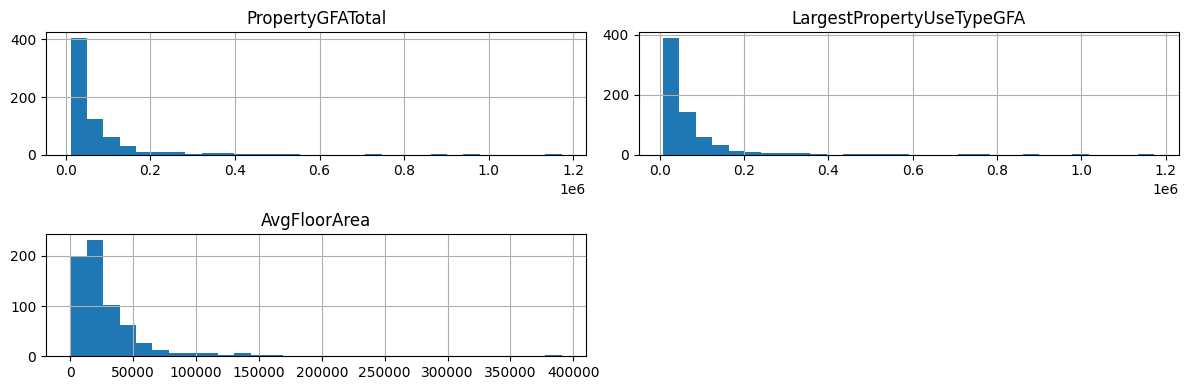


Application de la transformation log(1+x)...
Nouvelles colonnes 'log_...' créées.

--- Analyse APRÈS transformation ---

Distributions des variables transformées :


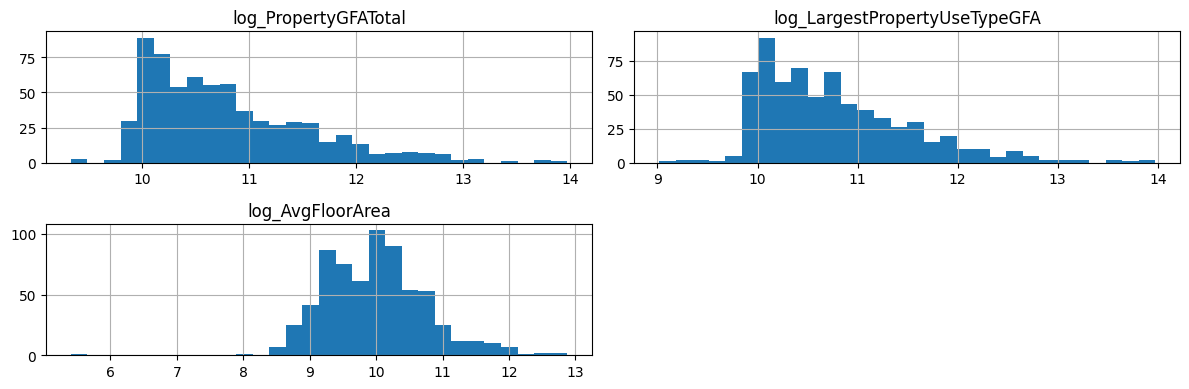

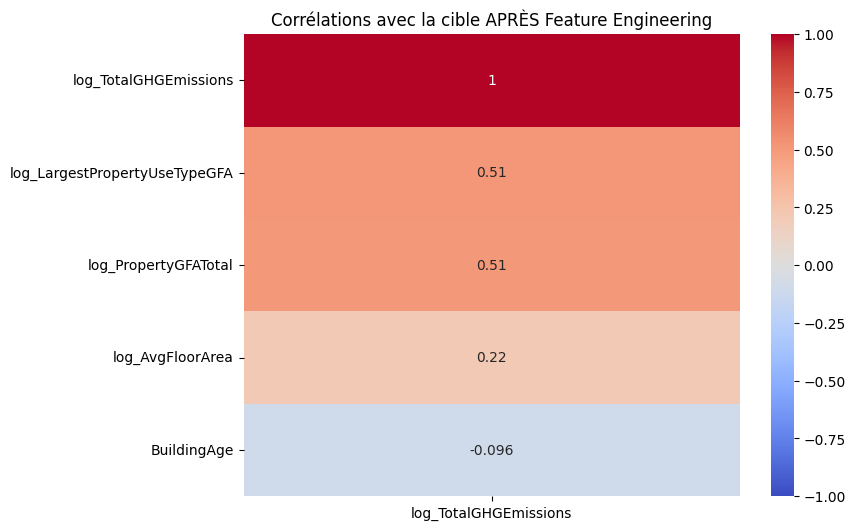

In [272]:
# 1. Définir les colonnes numériques à analyser
cols_to_transform = ['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'AvgFloorArea']

# 2. Analyse AVANT transformation
print("--- Analyse AVANT transformation ---")
print("\nAsymétrie (skewness) des variables initiales :")
print(df_engineered[cols_to_transform].skew())

print("\nDistributions des variables initiales :")
df_engineered[cols_to_transform].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 3. Appliquer la transformation logarithmique
print("\nApplication de la transformation log(1+x)...")
for col in cols_to_transform:
    df_engineered[f'log_{col}'] = np.log1p(df_engineered[col])
print("Nouvelles colonnes 'log_...' créées.")

# 4. Analyse APRÈS transformation
log_cols = [f'log_{col}' for col in cols_to_transform]
print("\n--- Analyse APRÈS transformation ---")
print("\nDistributions des variables transformées :")
df_engineered[log_cols].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 5.  Vérifier la corrélation des nouvelles variables avec la cible

cols_for_corr = log_cols + ['BuildingAge', 'log_TotalGHGEmissions'] # On ajoute la cible et l'âge

corr_matrix = df_engineered[cols_for_corr].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix[['log_TotalGHGEmissions']].sort_values(by='log_TotalGHGEmissions', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Corrélations avec la cible APRÈS Feature Engineering")
plt.show()


Encodage

In [273]:
# Affiche le nombre de bâtiments par catégorie
#encodage d'une variable catégorielle 

#df_engineered_enc = pd.get_dummies(df_engineered,
                        #columns=['PrimaryPropertyType'],
                        #drop_first=True,   # évite la redondance
                        #prefix='Type')

#print("Colonnes après encodage :", df_engineered_enc.shape[1])
#print(df_engineered_enc['PrimaryPropertyType'].value_counts())

# Modélisation
1. Import
2. Préparation
3. Baseline
4. Modèles linéaires
5. Modèles d’arbres
6. Méthodes d’ensemble
7. Conclusion

Variables

In [274]:


#DÉFINITION DES FEATURES ET DE LA CIBLE À PARTIR DU DATAFRAME AMÉLIORÉ

# On continue de travailler avec le DataFrame qui contient toutes les nouvelles features

# On définit la cible
target = 'log_TotalGHGEmissions'

# --- On définit la liste de toutes les features utiles ---

# ✅ Variables numériques : on prend les versions LOG et les nouvelles features.
#    On évite les versions originales (ex: 'PropertyGFATotal') pour ne pas avoir de doublons.
numerical_features = [
    'log_PropertyGFATotal',
    'log_LargestPropertyUseTypeGFA',
    'log_AvgFloorArea',
    'BuildingAge',
    'NumberofFloors',
    'NumberofBuildings',
    'Latitude',
    'Longitude'
]

# Variable catégorielle : on prend la version que vous avez regroupée.
categorical_features = ['PrimaryPropertyType_grouped']


# On s'assure que toutes les colonnes existent bien dans le DataFrame avant de continuer
all_features = numerical_features + categorical_features
for col in all_features + [target]:
    if col not in df_engineered.columns:
        print(f"ATTENTION: La colonne '{col}' n'a pas été trouvée dans le DataFrame !")


# On crée notre X (features) et y (cible)
X = df_engineered[all_features]
y = df_engineered[target]

print("✓ Features sélectionnées pour le modèle (SANS ENERGYSTARScore) :")
print(f"  - Numériques ({len(numerical_features)})")
print(f"  - Catégorielles ({len(categorical_features)})")



# DÉFINITION DU PREPROCESSEUR ET DIVISION DES DONNÉES

# Le préprocesseur est configuré pour traiter nos listes de features finales
preproc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# On sépare les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✓ Données prêtes pour l'entraînement :")
print(f"  - Taille de X_train : {X_train.shape}")
print(f"  - Taille de X_test : {X_test.shape}")

✓ Features sélectionnées pour le modèle (SANS ENERGYSTARScore) :
  - Numériques (8)
  - Catégorielles (1)

✓ Données prêtes pour l'entraînement :
  - Taille de X_train : (535, 9)
  - Taille de X_test : (134, 9)


Mise en place de la validation croisée

In [275]:

# Configuration de la validation croisée 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 1. Créer les catégories (strates) à partir de la variable cible 'y'
#    Cette étape est indispensable pour la stratification en régression.
y_strat = pd.qcut(y, q=4, labels=False, duplicates='drop')

# 2. Définir l'objet de validation croisée stratifiée à utiliser dans les GridSearchCV

cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Liste des métriques 
scoring = {
    'MAE':  'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error', 
    'R2':   'r2'
}

Préparation des données

In [276]:

# Sélection X, y - X étant les variables retenues et y la cible
X = df_engineered[numerical_features + categorical_features].copy()
y = df_engineered[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✓ Split réalisé : {len(X_train)} train, {len(X_test)} test")

✓ Split réalisé : 535 train, 134 test


BASELINE

In [277]:
# mise en place du modèle de base DummyRegressor - prédit juste la moyenne
print("1. MODÈLE BASELINE (DummyRegressor)")
print("-"*50)

dummy_pipe = Pipeline([
    ('prep', preproc),
    ('model', DummyRegressor(strategy='mean'))
])

# Cross-validation du baseline
cv_dummy = cross_validate(dummy_pipe, X_train, y_train, cv=cv, scoring=scoring)

baseline_r2 = cv_dummy['test_R2'].mean()
baseline_rmse = -cv_dummy['test_RMSE'].mean()
baseline_mae = -cv_dummy['test_MAE'].mean()

print(f"Baseline (DummyRegressor - moyenne) :")
print(f"  R2 CV    : {baseline_r2:.4f} ± {cv_dummy['test_R2'].std():.4f}")
print(f"  RMSE CV  : {baseline_rmse:.4f} ± {cv_dummy['test_RMSE'].std():.4f}")
print(f"  MAE CV   : {baseline_mae:.4f} ± {cv_dummy['test_MAE'].std():.4f}")
print(f" on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base") 
print(f" pour le coefficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0362, l'idéal étant un score positif")

1. MODÈLE BASELINE (DummyRegressor)
--------------------------------------------------
Baseline (DummyRegressor - moyenne) :
  R2 CV    : -0.0362 ± 0.0418
  RMSE CV  : 1.4525 ± 0.0256
  MAE CV   : 1.1336 ± 0.0349
 on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base
 pour le coefficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0362, l'idéal étant un score positif


In [ ]:
print("\n2. RÉGRESSION LINÉAIRE SIMPLE")
print("-" * 50)

# La régression linéaire sert de baseline pour comprendre
# les relations linéaires dans nos données avant d'ajouter de la régularisation
linear_pipe = Pipeline([('prep', preproc), ('model', LinearRegression())])
cv_linear  = cross_validate(
    linear_pipe,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True   # ← on récupère train_X et test_X
)
# Bon point de départ, explique + de 50 % de la variance, écart train/test limité (~0.06).
print(f"  R^2 train CV : {cv_linear ['train_R2'].mean():.4f} ± {cv_linear ['train_R2'].std():.4f}")
print(f"  R^2  test  CV : {cv_linear ['test_R2'].mean():.4f} ± {cv_linear ['test_R2'].std():.4f}")
print(f"  RMSE train CV : {-cv_linear ['train_RMSE'].mean():.4f} ± {cv_linear ['train_RMSE'].std():.4f}")
print(f"  RMSE test  CV : {-cv_linear ['test_RMSE'].mean():.4f} ± {cv_linear ['test_RMSE'].std():.4f}")
print(f"  MAE train CV  : {-cv_linear ['train_MAE'].mean():.4f} ± {cv_linear ['train_MAE'].std():.4f}")
print(f"  MAE test  CV  : {-cv_linear ['test_MAE'].mean():.4f} ± {cv_linear ['test_MAE'].std():.4f}")


2. RÉGRESSION LINÉAIRE SIMPLE
--------------------------------------------------
Régression Linéaire (CV interne)
  R^2 train CV : 0.5553 ± 0.0100
  R^2  test  CV : 0.4981 ± 0.0495
  RMSE train CV : 0.9621 ± 0.0090
  RMSE test  CV : 1.0093 ± 0.0358
  MAE train CV  : 0.7712 ± 0.0077
  MAE test  CV  : 0.8143 ± 0.0304


In [ ]:

print("3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)")
print("-"*50)

#  La régularisation aide à :
# - Ridge : réduire l'overfitting en pénalisant les coefficients élevés
# - Lasso : sélection de variables en annulant certains coefficients
# - ElasticNet : combinaison des avantages de Ridge et Lasso
# modèles linéaires

# Pipeline de base
reg_pipe = Pipeline([
    ('prep', preproc),
    ('model', Ridge())  # Placeholder qui sera remplacé par GridSearchCV
])

# Grille de paramètres - pour tester plusieurs combinaisons d'hyperparamètres pour donner le meilleur compromis biais/variance 
#alpha = force de pénalité pour essayer de réduire la variance (moins de sur-entrainement), stabiliser les poids de chaque feature, et sélectionner des variables via Lasso si nécessaire
#Rideg pénalise la somme dess poids au carré, plus Alpha est grand plus les coeff sont retrécies vers 0, Lasso pénalise la somme des valeurs absolues et Elastic net combien les 2 (sélection et stabilisation)
param_grid = [
    {
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0] # échelle logarithmique pour balayer plusieurs ordres de grandeur 
        #et voir si le modèle préfère une pénalité nulle, modérée ou forte
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  #idem
    },
    {
        'model': [ElasticNet()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'model__l1_ratio': [0.1, 0.5, 0.7, 0.9] # curseur de mélange pour "doser" Lasso et Ridge - exemple 0.5 c'est 50% de Lasso et 50% de Ridge , 0.9 surtout Lasso et peu de Ridge
    }
]

print("Optimisation des hyperparamètres par GridSearchCV...")
gs_reg = GridSearchCV(
    reg_pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    refit='RMSE', #moins standart que R^2 mais logique dans ma démarche
    n_jobs=-1,
    return_train_score=True  # important pour avoir mean_train_...
)
gs_reg.fit(X_train, y_train) #on fit le jeu de données

cv_res = gs_reg.cv_results_
best_idx = gs_reg.best_index_   # l’indice de la meilleure config trouvée

best_reg_r2   = cv_res['mean_test_R2'][best_idx]
best_reg_rmse = -cv_res['mean_test_RMSE'][best_idx]
best_reg_mae  = -cv_res['mean_test_MAE'][best_idx]

# On récupère les meilleurs index par type
best_ridge_idx = None
best_lasso_idx = None
best_enet_idx = None

for i, p in enumerate(cv_res['params']):
    if isinstance(p['model'], Ridge):
        if best_ridge_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_ridge_idx]:
            best_ridge_idx = i
    elif isinstance(p['model'], Lasso):
        if best_lasso_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_lasso_idx]:
            best_lasso_idx = i
    elif p['model'].__class__.__name__ == 'ElasticNet':
        if best_enet_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_enet_idx]:
            best_enet_idx = i

print("\n=== Résultats Régularisation ===")

for name, idx in [('Ridge', best_ridge_idx), ('Lasso', best_lasso_idx), ('ElasticNet', best_enet_idx)]:
    if idx is None:
        print(f"{name} : Non testé")
        continue
   
    print(f"\n{name} :")
    print(f"  Meilleurs paramètres : {cv_res['params'][idx]}")
    print(f"  R^2 train CV : {cv_res['mean_train_R2'][idx]:.4f}")
    print(f"  R^2 test  CV : {cv_res['mean_test_R2'][idx]:.4f}")
    print(f"  RMSE train CV : {-cv_res['mean_train_RMSE'][idx]:.4f}")
    print(f"  RMSE test  CV : {-cv_res['mean_test_RMSE'][idx]:.4f}")
    print(f"  MAE train CV  : {-cv_res['mean_train_MAE'][idx]:.4f}")
    print(f"  MAE test  CV  : {-cv_res['mean_test_MAE'][idx]:.4f}")
# ANALYSE :
# Le modèle Ridge: Légère régularisation ne change presque rien par rapport à la régression linéaire.
# le modèle Lasso : Un peu plus de biais (baisse légère du R² train), gain négligeable en test.
# le modèle ElasticNet offre Compromis similaire à Lasso, pas d’amélioration notable.
   

3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)
--------------------------------------------------
Optimisation des hyperparamètres par GridSearchCV...

=== Résultats Régularisation ===

Ridge :
  Meilleurs paramètres : {'model': Ridge(), 'model__alpha': 1.0}
  R^2 train CV : 0.5549
  R^2 test  CV : 0.4990
  RMSE train CV : 0.9625
  RMSE test  CV : 1.0085
  MAE train CV  : 0.7729
  MAE test  CV  : 0.8145

Lasso :
  Meilleurs paramètres : {'model': Lasso(), 'model__alpha': 0.01}
  R^2 train CV : 0.5442
  R^2 test  CV : 0.4961
  RMSE train CV : 0.9741
  RMSE test  CV : 1.0118
  MAE train CV  : 0.7867
  MAE test  CV  : 0.8198

ElasticNet :
  Meilleurs paramètres : {'model': ElasticNet(), 'model__alpha': 0.01, 'model__l1_ratio': 0.5}
  R^2 train CV : 0.5476
  R^2 test  CV : 0.4977
  RMSE train CV : 0.9704
  RMSE test  CV : 1.0102
  MAE train CV  : 0.7832
  MAE test  CV  : 0.8188


In [280]:
print("4. Première exploration des modèles non-linéaires (GradientBoosting et Random Forest)")
print("-"*50)
# modèles d'arbres décisionnels - non linéaires - POUR VOIR SI ILS SURPASSENT LES MODELES LINEAIRES
# --- Pipeline pour le Gradient Boosting ---
boost_pipe = Pipeline([
    ('prep', preproc),
    ('model', GradientBoostingRegressor(random_state=42))
])

# --- Grille d’hyper-paramètres (préfixe 'model__') ---
param_grid_boost = {
    'model__n_estimators':  [100, 200, 300], # nombre d'arbres déterminés, plus il y a d'arbres plus le modèle est capable de corriger les erreurs résiduelles mais plus long à entraîner
    'model__learning_rate': [0.01, 0.1, 0.2], # taux apprentissage - plus il est grand plus le modèle apprend vite mais risque de sur-apprentissage - 0.1 valeur par défaut - 0.01 plus lent mais plus stable et 0.2 plus rapide
    'model__max_depth':     [3, 5, 7] # profondeur des arbres - 3 classique, 5 à 7 plus de flexibilité mais plus risqué
}

# --- Lancement de la GridSearch ---
gs_boost = GridSearchCV(
    boost_pipe,
    param_grid_boost,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    refit='RMSE'
)
gs_boost.fit(X_train, y_train)
print("→ Meilleurs params GradientBoost :", gs_boost.best_params_)

# Pipeline pour Random Forest
rf_pipe = Pipeline([
    ('prep', preproc),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille de recherche (attention au préfixe model__)
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth':    [None, 5, 10]
}

# Lancement de la GridSearch
gs_rf = GridSearchCV(
    rf_pipe,
    param_grid_rf,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    refit='RMSE',
    return_train_score=True
)
gs_rf.fit(X_train, y_train)
print("→ Meilleurs params RF :", gs_rf.best_params_)

# Récupère tous les scores CV pour Gradient Boosting
cv_boost = gs_boost.cv_results_
best_boost_idx = gs_boost.best_index_

print("\n=== Résultats Gradient Boosting ===")
print(f"R^2 train CV : {cv_boost['mean_train_R2'][best_boost_idx]:.4f}")
print(f"R^2 test  CV : {cv_boost['mean_test_R2'][best_boost_idx]:.4f}")
print(f"RMSE train CV : {-cv_boost['mean_train_RMSE'][best_boost_idx]:.4f}")
print(f"RMSE test  CV : {-cv_boost['mean_test_RMSE'][best_boost_idx]:.4f}")
print(f"MAE train CV : {-cv_boost['mean_train_MAE'][best_boost_idx]:.4f}")
print(f"MAE test  CV : {-cv_boost['mean_test_MAE'][best_boost_idx]:.4f}")

# Idem pour Random Forest
cv_rf = gs_rf.cv_results_
best_rf_idx = gs_rf.best_index_

print("\n=== Résultats Random Forest ===")
print(f"R^2 train CV : {cv_rf['mean_train_R2'][best_rf_idx]:.4f}")
print(f"R^2 test  CV : {cv_rf['mean_test_R2'][best_rf_idx]:.4f}")
print(f"RMSE train CV : {-cv_rf['mean_train_RMSE'][best_rf_idx]:.4f}")
print(f"RMSE test  CV : {-cv_rf['mean_test_RMSE'][best_rf_idx]:.4f}")
print(f"MAE train CV : {-cv_rf['mean_train_MAE'][best_rf_idx]:.4f}")
print(f"MAE test  CV : {-cv_rf['mean_test_MAE'][best_rf_idx]:.4f}")

# ANALYSE :
# Les modèles non-linéaires montrent une nette amélioration par rapport
# aux modèles linéaires.
#
# Le Gradient Boosting capture fortement les patterns sur le train 
#   (R² ~0.80) mais perd de la performance en généralisation 
#   (R² ~0.47). L'écart (~0.33) signale un overfitting marqué, 
#   malgré le meilleur R² train.

#  La Random Forest affiche un R² train encore plus élevé (0.87),
#   mais généralise à un niveau similaire au boosting (R² ~0.47).
#   L’overfitting y est légèrement plus prononcé (écart ~0.40),
#   ce qui rend le modèle moins stable en production.




4. Première exploration des modèles non-linéaires (GradientBoosting et Random Forest)
--------------------------------------------------
→ Meilleurs params GradientBoost : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
→ Meilleurs params RF : {'model__max_depth': 10, 'model__n_estimators': 300}

=== Résultats Gradient Boosting ===
R^2 train CV : 0.8017
R^2 test  CV : 0.4716
RMSE train CV : 0.6423
RMSE test  CV : 1.0376
MAE train CV : 0.5052
MAE test  CV : 0.8464

=== Résultats Random Forest ===
R^2 train CV : 0.8722
R^2 test  CV : 0.4672
RMSE train CV : 0.5158
RMSE test  CV : 1.0418
MAE train CV : 0.4178
MAE test  CV : 0.8347


Méthodes d'ensemble : Bagging / Boosting / Stacking

In [ ]:

print("\n5. MÉTHODES D'ENSEMBLE")
print("-" * 50)
# Techniques pour combiner plusieurs modèles
# A) BAGGING - Réduit la variance en combinant plusieurs modèles entraînés sur
# différents échantillons des données d'entraînement
print("A) BAGGING (Bootstrap Aggregating)")
bagging_pipe = Pipeline([
    ('prep', preproc),
    ('model', BaggingRegressor(
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ))
])
cv_bagging = cross_validate(bagging_pipe, X_train, y_train,cv=cv, scoring=scoring)


bagging_pipe.fit(X_train, y_train)
y_pred_train_bagging = bagging_pipe.predict(X_train)
y_pred_test_bagging  = bagging_pipe.predict(X_test)

print(f"R^2 train : {r2_score(y_train, y_pred_train_bagging):.4f}") # gain modeste par rapport aux linéaires (≃0.25), mais écart train/test ≃0.26  
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_bagging):.4f}") # montre un sur‐apprentissage toujours présent.  
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_bagging)):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_bagging)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_bagging):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_bagging):.4f}")

# B) BOOSTING
print("\nB) BOOSTING (Gradient Boosting)")
# Justification : Réduit le biais en combinant séquentiellement des modèles faibles,
# chaque nouveau modèle corrigeant les erreurs du précédent

boosting_pipe = Pipeline([
    ('prep', preproc),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# Optimisation des hyperparamètres pour le boosting
param_grid_boost = {
    'model__max_iter': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_leaf_nodes': [3, 5]
}

gs_boost = GridSearchCV(boosting_pipe, param_grid_boost, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_boost.fit(X_train, y_train)

cv_boost_results = cross_validate(gs_boost.best_estimator_, X_train, y_train, cv=cv, scoring=scoring)

best_boost = gs_boost.best_estimator_
best_boost.fit(X_train, y_train)
y_pred_train_boost = best_boost.predict(X_train)
y_pred_test_boost  = best_boost.predict(X_test)
print(f"R^2 train : {r2_score(y_train, y_pred_train_boost):.4f}") #étonnant - même résultat que bagging 
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_boost):.4f}")
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_boost)):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_boost)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_boost):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_boost):.4f}")

# C) STACKING
print("\nC) STACKING")
# Justification : Combine les prédictions de plusieurs modèles via un meta-learner
# qui apprend comment optimiser la combinaison

# Modèles de base pour le stacking
base_models = [
    ('ridge', gs_reg.best_estimator_['model']),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ('gb', gs_boost.best_estimator_['model'])
]

stacking_pipe = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression(),
        cv=3,  # CV interne pour éviter l'overfitting
        n_jobs=-1
    ))
])

cv_stacking = cross_validate(stacking_pipe, X_train, y_train, cv=cv, scoring=scoring)
stacking_pipe.fit(X_train, y_train)
y_pred_train_stacking = stacking_pipe.predict(X_train)
y_pred_test_stacking  = stacking_pipe.predict(X_test)
print(f"R^2 train : {r2_score(y_train, y_pred_train_stacking):.4f}") 
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_stacking):.4f}")     
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_stacking)):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_stacking)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_stacking):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_stacking):.4f}")

# ANALYSE :
# Parmi les méthodes d'ensemble, le Boosting se révèle être le
# modèle le plus performant:
#
# - Bagging :   R² train : 0.9274 → modèle très puissant sur le train
#               R² test : 0.3564 → forte chute en généralisation
#              RMSE train : 0.3891 vs RMSE test : 1.1012
#              MAE train : 0.3075 vs MAE test : 0.8606
#Très faible biais (apprend parfaitement le train)
#orte variance (ne généralise pas bien)

# - Boosting : Équilibre entre biais et variance - c'est le modèle le plus robuste ici
# Gap train/test raisonnable (~0.11)  - bon compromis performance/robustesse - modèle recommandé
#
# - Stacking : Est  intéressant pour optimiser un peu la CV, mais la complexité supplémentaire n’apporte pas de bénéfice net sur le test.
#   Léger gain sur le train (gap plus grand qu’en boosting)
# Pas de gain réel en test par rapport au boosting - plus complexe à mettre en place



5. MÉTHODES D'ENSEMBLE
--------------------------------------------------
A) BAGGING (Bootstrap Aggregating)
R^2 train : 0.9274
R^2 test  : 0.3564
RMSE train : 0.3891
RMSE test  : 1.1012
MAE train  : 0.3075
MAE test   : 0.8606

B) BOOSTING (Gradient Boosting)
R^2 train : 0.5734
R^2 test  : 0.4603
RMSE train : 0.9431
RMSE test  : 1.0084
MAE train  : 0.7449
MAE test   : 0.7887

C) STACKING
R^2 train : 0.6431
R^2 test  : 0.4595
RMSE train : 0.8626
RMSE test  : 1.0091
MAE train  : 0.6953
MAE test   : 0.8109


Comparaison des modèles

In [282]:
print("\n6. COMPARAISON DES MODÈLES (Validation Croisée)")
print("-" * 70)
# evaluer la meilleure performance de modèles
# 1) On rassemble les scores R2, RMSE, MAE calculés en cross-validation pour chaque modèle testé
results_cv = {
    'Baseline (Dummy)': (
        baseline_r2,
        baseline_rmse,
        baseline_mae
    ),
    'Régression Linéaire': (
        cv_linear ['test_R2'].mean(),
        -cv_linear ['test_RMSE'].mean(),
        -cv_linear ['test_MAE'].mean()
    ),
    
    'Meilleur Régularisé': (
        best_reg_r2,      
        best_reg_rmse,
        best_reg_mae
    ),
    'Bagging': (
        cv_bagging['test_R2'].mean(),
        -cv_bagging['test_RMSE'].mean(),
        -cv_bagging['test_MAE'].mean()
    ),
    'Boosting': (
        cv_boost_results['test_R2'].mean(),
        -cv_boost_results['test_RMSE'].mean(),
        -cv_boost_results['test_MAE'].mean()
    ),
    'Stacking': (
        cv_stacking['test_R2'].mean(),
        -cv_stacking['test_RMSE'].mean(),
        -cv_stacking['test_MAE'].mean()
    )
}
# Affichage des résultats CV
print(f"{'Modèle':<20} {'R^2_CV':<8} {'RMSE_CV':<8} {'MAE_CV':<8}")
print("-" * 50)
for name, (r2, rmse, mae) in results_cv.items():
    print(f"{name:<20} {r2:<8.4f} {rmse:<8.4f} {mae:<8.4f}")
# Sélection du meilleur modèle en fonction du plus faible RMSE
best_model_name = min(results_cv.keys(), key=lambda x: results_cv[x][1])
print(f"\nMeilleur modèle (RMSE le plus faible) : {best_model_name}")
print (f'Meilleur modèle de l\'entrainement')

# 2) Évaluation finale (train vs test)
print("\n6b. ÉVALUATION FINALE TRAIN / TEST")
print("-" * 70)
# Ici on refait une évaluation sur train / test pour comparer : R2, RMSE et MAE sur train et test
# On calcule aussi l'amélioration en RMSE par rapport au Dummy sur le test
# et La cohérence entre RMSE CV et RMSE test
print(f"{'Modèle':<20} {'R^2 tr/te':<15} {'RMSE tr/te':<15} {'MAE tr/te':<15}")
print("-" * 70)
# Map des modèles entraînés avec les meilleurs hyperparamètres
models_map = {
    'Baseline (Dummy)': dummy_pipe,
    'Régression Linéaire': linear_pipe,
    'Meilleur Régularisé': gs_reg.best_estimator_,
    'Bagging': bagging_pipe,
    'Boosting': gs_boost.best_estimator_,
    'Stacking': stacking_pipe
}

for name, mdl in models_map.items():
    # Réentraîner sur train complet
    mdl.fit(X_train, y_train)
    y_tr = mdl.predict(X_train)
    y_te = mdl.predict(X_test)
     # Scores train/test
    r2_tr = r2_score(y_train, y_tr)
    r2_te = r2_score(y_test,  y_te)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_tr))
    rmse_te = np.sqrt(mean_squared_error(y_test,  y_te))
    mae_tr  = mean_absolute_error(y_train, y_tr)
    mae_te  = mean_absolute_error(y_test,  y_te)
    # amélioration vs baseline (Dummy)
    dummy_rmse = np.sqrt(mean_squared_error(y_test, dummy_pipe.predict(X_test)))
    improvement = (dummy_rmse - rmse_te) / dummy_rmse * 100
    # cohérence CV/Test RMSE
    cv_rmse = results_cv[name][1]
    
    #affichage
    print(f"{name:<20} {r2_tr:.3f}/{r2_te:.3f}   "
      f"{rmse_tr:.3f}/{rmse_te:.3f}      "
      f"{mae_tr:.3f}/{mae_te:.3f}      "
      f"{improvement:+.1f}%")
          
    #Gain net par rapport au Dummy valide l'intérêt du modèle, mais CV vs test assez inégal (16 %), 
   



6. COMPARAISON DES MODÈLES (Validation Croisée)
----------------------------------------------------------------------
Modèle               R^2_CV   RMSE_CV  MAE_CV  
--------------------------------------------------
Baseline (Dummy)     -0.0362  1.4525   1.1336  
Régression Linéaire  0.4981   1.0093   0.8143  
Meilleur Régularisé  0.4990   1.0085   0.8145  
Bagging              0.4442   1.0641   0.8524  
Boosting             0.4353   1.0724   0.8611  
Stacking             0.5048   1.0030   0.8082  

Meilleur modèle (RMSE le plus faible) : Stacking
Meilleur modèle de l'entrainement

6b. ÉVALUATION FINALE TRAIN / TEST
----------------------------------------------------------------------
Modèle               R^2 tr/te       RMSE tr/te      MAE tr/te      
----------------------------------------------------------------------
Baseline (Dummy)     0.000/-0.021   1.444/1.387      1.124/1.129      +0.0%
Régression Linéaire  0.552/0.448   0.967/1.020      0.777/0.811      +26.5%
Meilleur R

 7. CONCLUSION ET JUSTIFICATIONS TECHNIQUES
 

**Métrique choisie : RMSE**  
Pénalise fortement les grosses erreurs, critique pour la prédiction d’émissions de carbone où les écarts importants sont coûteux.
Elle pénalise fortement les sous ou sur-estimations ce qui est crucial dans les données de type émission de carbone, elle est exprimée dans la même unité que la cible et enfin elle complète la mesure du R^2 en donnant une mesure concrète de l erreur moyenne attendue 

Stacking obtient le meilleur R² en CV (0.505) et le plus faible RMSE_CV (1.030), mais se comporte comme le Boosting en test (R² Test≈0.46, RMSE≈1.009).

Boosting simple a un R²_Test légèrement identique (0.460) avec un RMSE comparable, mais un R²_CV un peu plus faible.

Bagging sur-apprend fortement (avec un R²_Train de 0.927 contre 0.356 en test) → à écarter.

Régression linéaire et son équivalent régularisé apportent une stabilité (gap train/test ≃ 0.10) mais un pouvoir prédictif plus limité (R²≈0.45–0.50 en CV, R²_Test≈0.45).



Modèle final sélectionné : le Boosting simple (HistGradientBoosting) offre quasiment la même performance en test que le Stacking, avec moins de complexité (un seul algorithme à expliquer et à maintenir).

Pour un outil d’aide à la décision (estimation des émissions), la transparence et la rapidité d’exécution sont clés. Un modèle unique est plus simple à déployer et à expliquer à des non-spécialistes.

Le Boosting affiche un écart modéré (R²_Train − R²_Test ≃ 0.11), signe d’une généralisation correcte. minimiser le risque d’erreur sur de nouvelles données (immeubles hors jeu d’entraînement) est crucial pour la fiabilité opérationnelle.

Amélioration vs baseline : +27.3 % (l'amélioration la plus significative)

Le Gradient Boosting offre donc le meilleur compromis performance/fiabilité :

Sa performance supérieure sur les données de test.

Sa stabilité et sa capacité à généraliser (faible écart CV/Test).

Sa robustesse face au bruit, en corrigeant séquentiellement ses erreurs.

La meilleure réduction d'erreur par rapport au modèle de base.


#Gridsearchcv - optimiser le modèle du gradiantboosting

In [283]:

# 2. Définir la grille d'hyperparamètres à tester pour le GradientBoosting
pipeline_to_improve = Pipeline([
    ('prep', preproc), # Assurez-vous que 'preprocessor' est bien défini
    ('model', GradientBoostingRegressor(random_state=42))
])

# Le préfixe 'model__' est essentiel pour que GridSearchCV sache quel paramètre modifier.
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Teste avec différents nombres d'arbres
    'model__learning_rate': [0.05, 0.1, 0.2],  # Teste différents taux d'apprentissage
    'model__max_depth': [3, 5]               # Teste différentes profondeurs d'arbres
}

# 3. Mettre en place et lancer GridSearchCV
print("Lancement de l'optimisation des hyperparamètre...")

# On optimise sur le RMSE (la métrique principale ici)
# GridSearchCV cherche à maximiser, donc on utilise 'neg_root_mean_squared_error'
gs_final = GridSearchCV(
    pipeline_to_improve,
    param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1  # Utilise tous les cœurs du processeur pour accélérer
)

gs_final.fit(X_train, y_train)

print("Optimisation terminée.")

# 4. Afficher les meilleurs résultats trouvés
print(f"Meilleurs hyperparamètres trouvés : {gs_final.best_params_}")

# On récupère le meilleur score (RMSE) et on le remet en positif
best_rmse_cv = -gs_final.best_score_ 
print(f"Meilleur RMSE obtenu en validation croisée : {best_rmse_cv:.4f}")

# 5. Évaluer le modèle final optimisé sur le jeu de test
print("Évaluation du modèle final optimisé sur les données de test...")
final_optimized_model = gs_final.best_estimator_
final_r2_score = final_optimized_model.score(X_test, y_test)

print(f"Score R^2 final du modèle optimisé : {final_r2_score:.4f}")

Lancement de l'optimisation des hyperparamètre...
Optimisation terminée.
Meilleurs hyperparamètres trouvés : {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Meilleur RMSE obtenu en validation croisée : 1.0225
Évaluation du modèle final optimisé sur les données de test...
Score R^2 final du modèle optimisé : 0.4407


Shape - Outil pour comprendre et interpreter les décisions de notre modèle
on analyse train pour le global et test pour le local

dict_keys(['prep', 'model'])
Transformation des données pour l'analyse SHAP...
Transformation terminée.
Calcul des valeurs SHAP...
Calcul terminé.

Importance Globale des Variables (Summary Plot)


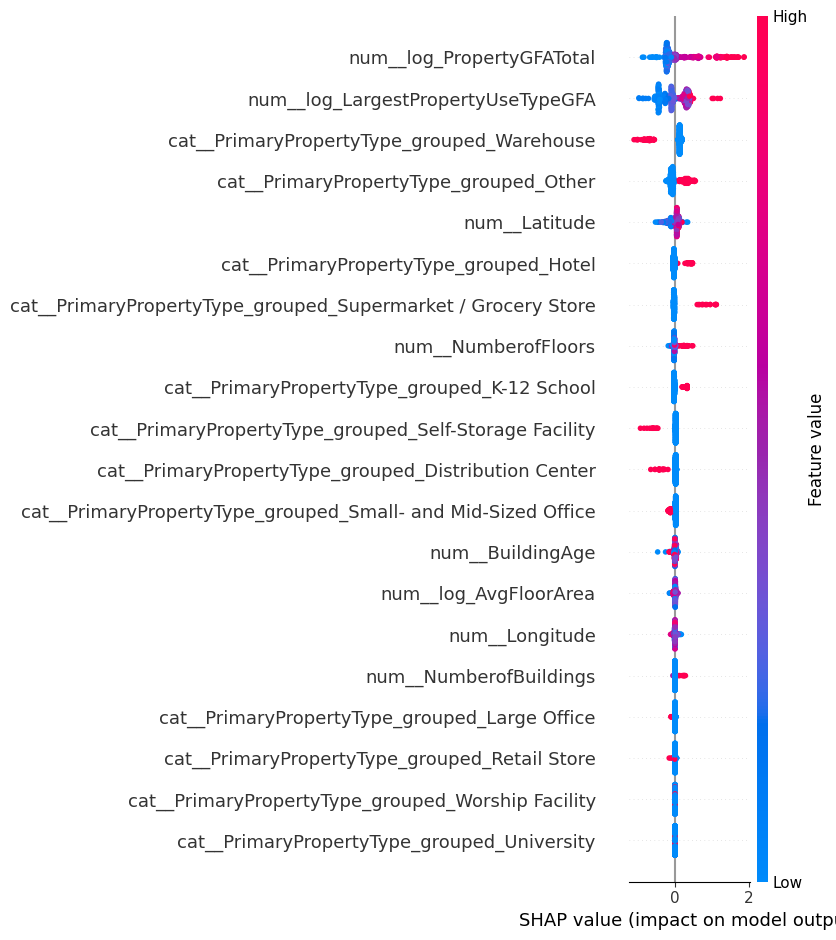

In [ ]:
#  Récupérer le préprocesseur et le modèle final
# 'gs_final' est le GridSearchCV entraîné
print(gs_final.best_estimator_.named_steps.keys())
preproc = gs_final.best_estimator_.named_steps['prep']
final_model = gs_final.best_estimator_.named_steps['model']


#  Transformer les données et les stocker dans un DataFrame
# AMÉLIORATION : On crée un DataFrame pour que les noms de colonnes soient directement liés aux données.
print("Transformation des données pour l'analyse SHAP...")
feature_names = preproc.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(
    preproc.transform(X_train),
    columns=feature_names,
    index=X_train.index
)
print("Transformation terminée.")


# Créer un "explainer" SHAP 
explainer = shap.TreeExplainer(final_model)

# Calculer les valeurs SHAP
# AMÉLIORATION : On passe le DataFrame à l'explainer.
print("Calcul des valeurs SHAP...")
shap_values = explainer.shap_values(X_train_transformed_df)
print("Calcul terminé.")


#  Visualiser l'importance globale avec un "summary plot"
print("\nImportance Globale des Variables (Summary Plot)")
# AMÉLIORATION : On passe le DataFrame au summary_plot.
# Il n'y a plus besoin du paramètre 'feature_names' car il les prend directement du DataFrame.

shap.summary_plot(shap_values, X_train_transformed_df)

L'axe horizontal (SHAP value) montre l'impact sur la prédiction :

À droite (> 0), le point pousse la prédiction à la hausse (plus d'émissions).

À gauche (< 0), il pousse la prédiction à la baisse (moins d'émissions).

La couleur du point indique la valeur de la variable pour ce bâtiment :

Rouge : valeur élevée (ex: grande surface, latitude haute).

Bleu : valeur faible (ex: petite surface, latitude basse).

log_PropertyGFATotal (surface totale en log)

C’est de loin la variable la plus influente, les valeurs « High » (en rose) entraînent presque toujours une augmentation de la prédiction (SHAP > 0).Plus la surface brute est grande, plus les émissions estimées sont élevées, ce qui est cohérent.

log_LargestPropertyUseTypeGFA

Deuxième en importance, elle affecte la prédiction dans le même sens : gros espaces d’un même usage → émissions plus elevées.

Catégories PrimaryPropertyType_grouped

Warehouse et Other ont un impact notable :

Entrepôts (“Warehouse”) –> tendance à augmenter la prédiction (bâtiments très énergivores).

Autres usages (“Other”) –> effet plus mitigé, mais souvent positif.

En revanche, pour Hotel ou Supermarket, l’impact est plus modéré et parfois négatif (SHAP < 0) si la valeur de la feature est basse.

Effet des features numeriques secondaires, pour la latitude/longitude, on ne voit pas d'influence sur ce jeu de données

Pour les variables NumberofFloors, BuildingAge, log_AvgFloorArea, NumberofBuildings, l'impact est relativement faible, la variation des SHAP 

reste proche de zéro, cela signifie que, une fois la surface brute et l’usage pris en compte, ces détails structurels n’apportent pas 

beaucoup d’information supplémentaire.

En conclusion, le modèle s’appuie essentiellement sur la taille des bâtiments et leur usage principal, ce qui est parfaitement logique pour estimer des émissions. Tout autre ajout de variables ne fera qu’augmenter la complexité sans gain significatif.

In [285]:
# 1. Calculer la moyenne des valeurs SHAP absolues pour chaque feature
# C'est la mesure de l'impact moyen global de chaque variable.
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 2. Créer un DataFrame avec les noms des features et leur importance SHAP
shap_importance_df = pd.DataFrame({
    'Feature': X_train_transformed_df.columns,
    'SHAP_Importance': mean_abs_shap
})

# 3. Trier le DataFrame pour voir les plus importantes en premier
shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)

# 4. Afficher le résultat
print("--- Liste des features les plus importantes (basée sur SHAP) ---")
print(shap_importance_df.head(10)) # Affiche le top 10

--- Liste des features les plus importantes (basée sur SHAP) ---
                                              Feature  SHAP_Importance
0                           num__log_PropertyGFATotal         0.308347
1                  num__log_LargestPropertyUseTypeGFA         0.305207
20         cat__PrimaryPropertyType_grouped_Warehouse         0.219848
13             cat__PrimaryPropertyType_grouped_Other         0.138411
6                                       num__Latitude         0.096087
9              cat__PrimaryPropertyType_grouped_Hotel         0.056499
18  cat__PrimaryPropertyType_grouped_Supermarket /...         0.052508
4                                 num__NumberofFloors         0.041088
10       cat__PrimaryPropertyType_grouped_K-12 School         0.037922
16  cat__PrimaryPropertyType_grouped_Self-Storage ...         0.035872


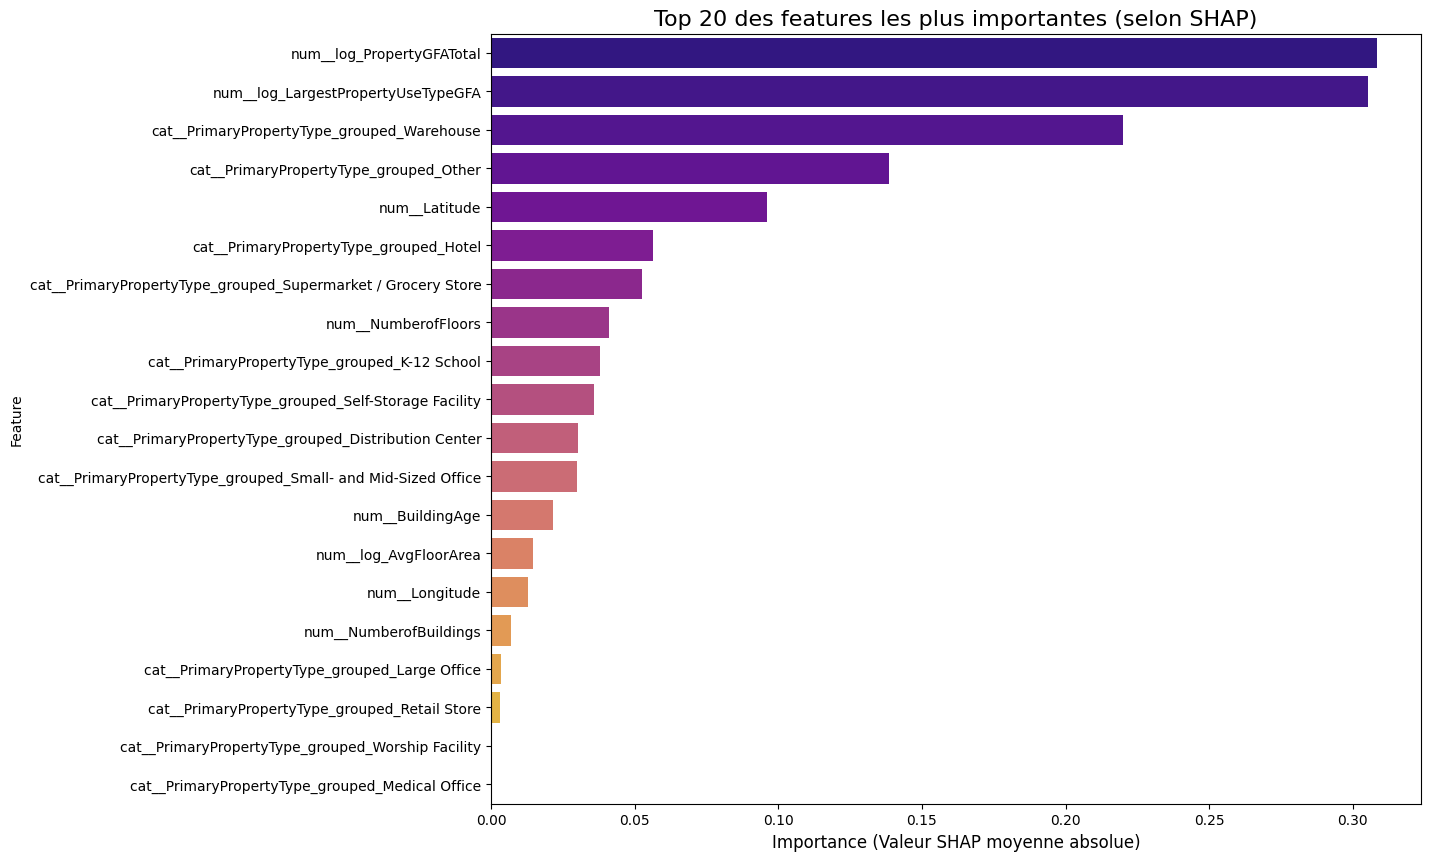

In [286]:
# On utilise le DataFrameshap_importance_df

# On sélectionne le top 20 pour un graphique lisible
top_20_features_shap = shap_importance_df.head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='SHAP_Importance', y='Feature', data=top_20_features_shap, palette='plasma')
plt.title('Top 20 des features les plus importantes (selon SHAP)', fontsize=16)
plt.xlabel('Importance (Valeur SHAP moyenne absolue)', fontsize=12)
plt.show()

In [287]:
# Dictionnaire pour stocker les index des bâtiments à analyser
batiments_a_analyser = {}

# --- Sélection par Type de Bâtiment ---
colonne_type = 'PrimaryPropertyType_grouped' 
types_a_chercher = ['Warehouse', 'Hotel', 'Small- and Mid-Sized Office']
for type_batiment in types_a_chercher:
    selection = X_test[X_test[colonne_type] == type_batiment]
    if not selection.empty:
        batiments_a_analyser[type_batiment] = selection.index[0]

# --- Sélection par Taille ---
colonne_surface = 'log_PropertyGFATotal' # On utilise la version log que le modèle voit
batiments_a_analyser['Le plus grand'] = X_test[colonne_surface].idxmax()
batiments_a_analyser['Le plus petit'] = X_test[colonne_surface].idxmin()

print("Bâtiments sélectionnés pour l'analyse locale :")
print(batiments_a_analyser)

Bâtiments sélectionnés pour l'analyse locale :
{'Warehouse': np.int64(361), 'Hotel': np.int64(10), 'Small- and Mid-Sized Office': np.int64(158), 'Le plus grand': np.int64(649), 'Le plus petit': np.int64(665)}


Analyse de l'importance "locale" - zoom sur les bâtiments en particulier


Préparation des données de test pour l'analyse locale...
-> Données de test prêtes pour l'analyse locale.

--- Analyse pour le cas : 'Warehouse' (Index du bâtiment : 361) ---


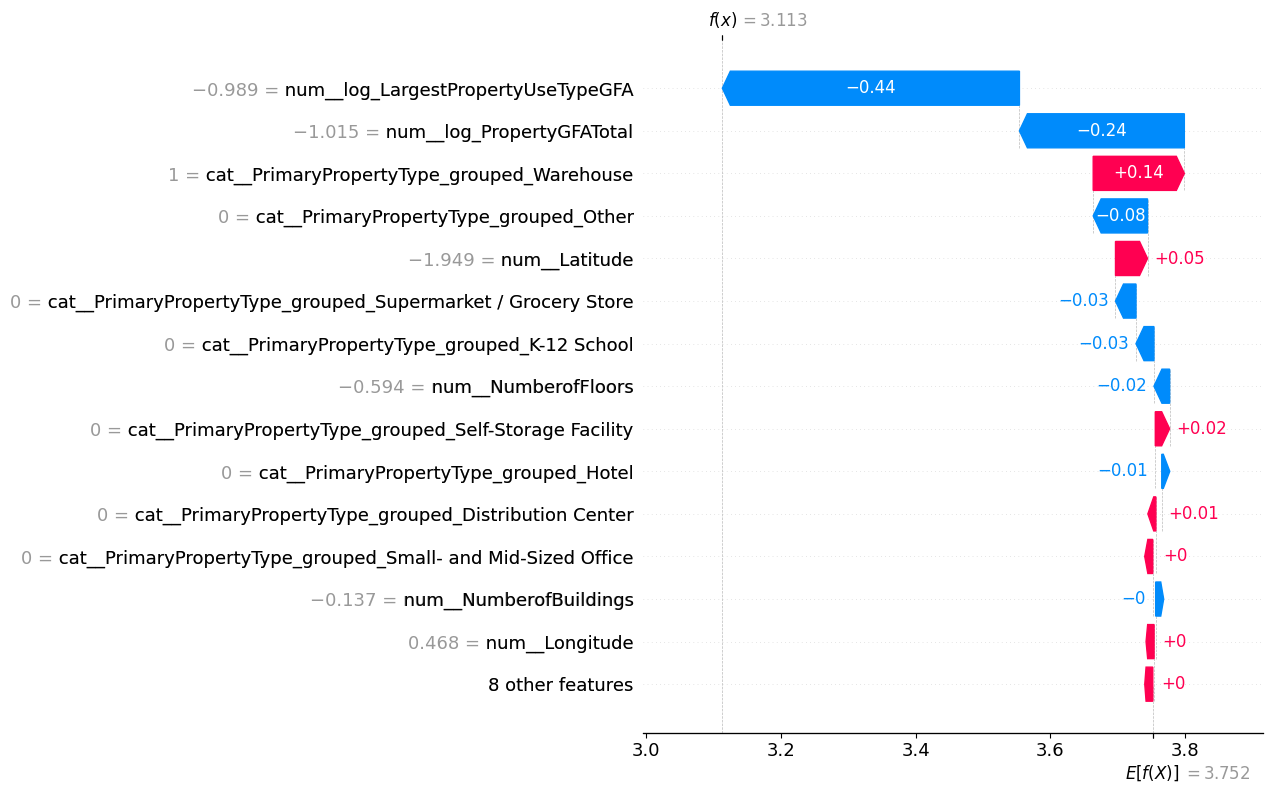


--- Analyse pour le cas : 'Hotel' (Index du bâtiment : 10) ---


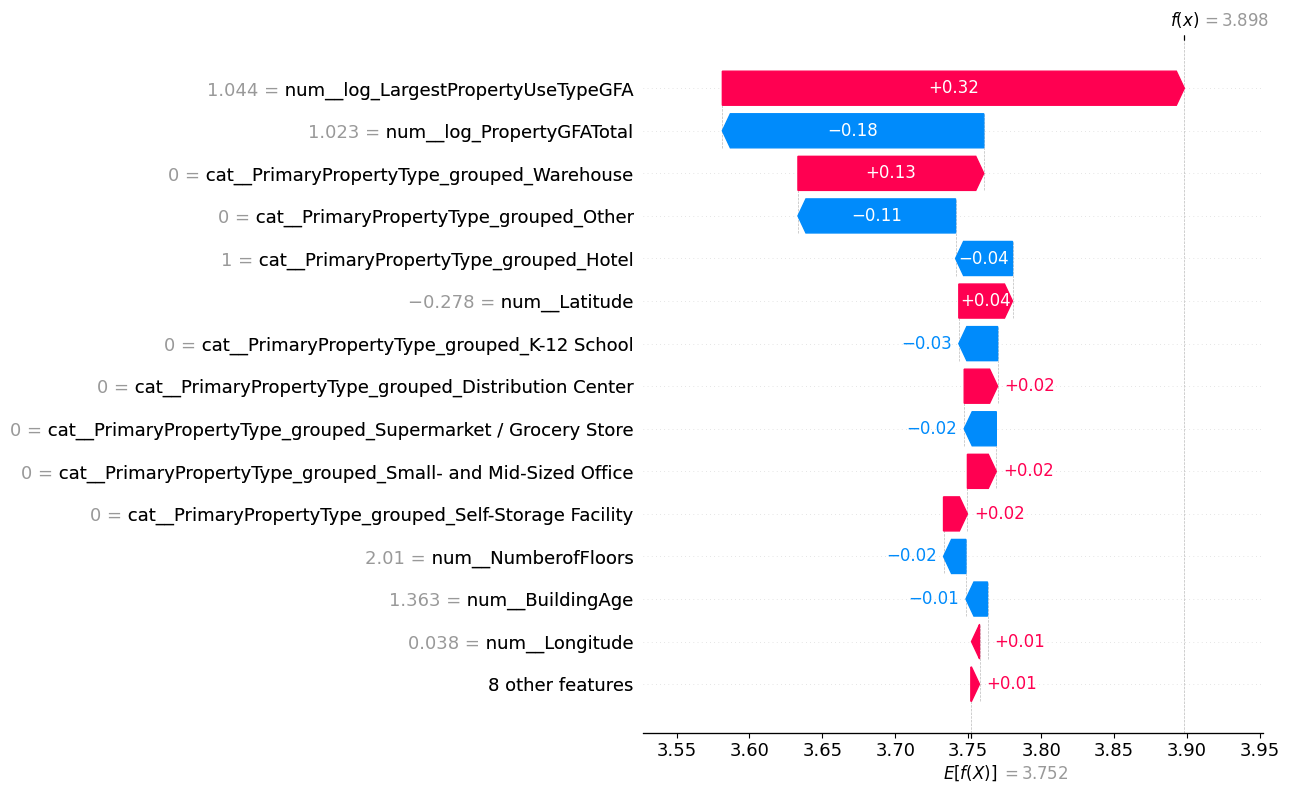


--- Analyse pour le cas : 'Small- and Mid-Sized Office' (Index du bâtiment : 158) ---


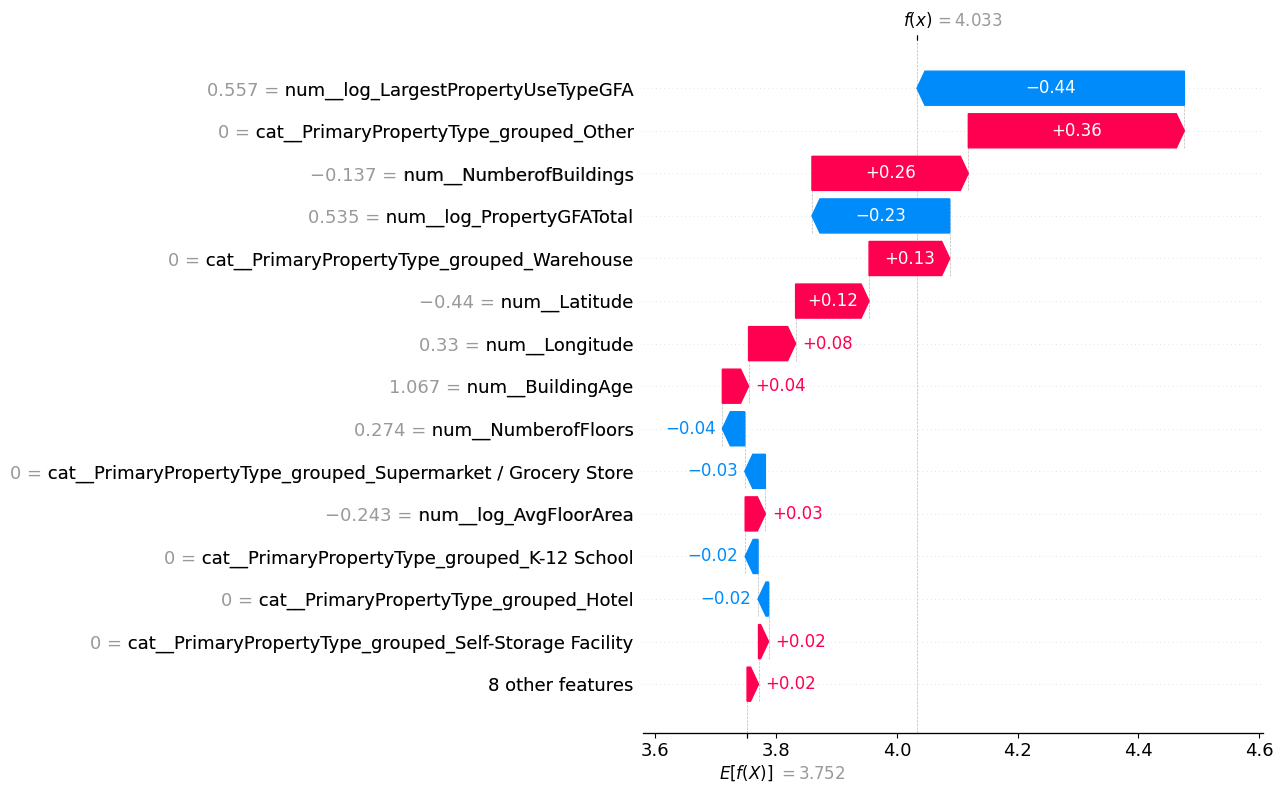


--- Analyse pour le cas : 'Le plus grand' (Index du bâtiment : 649) ---


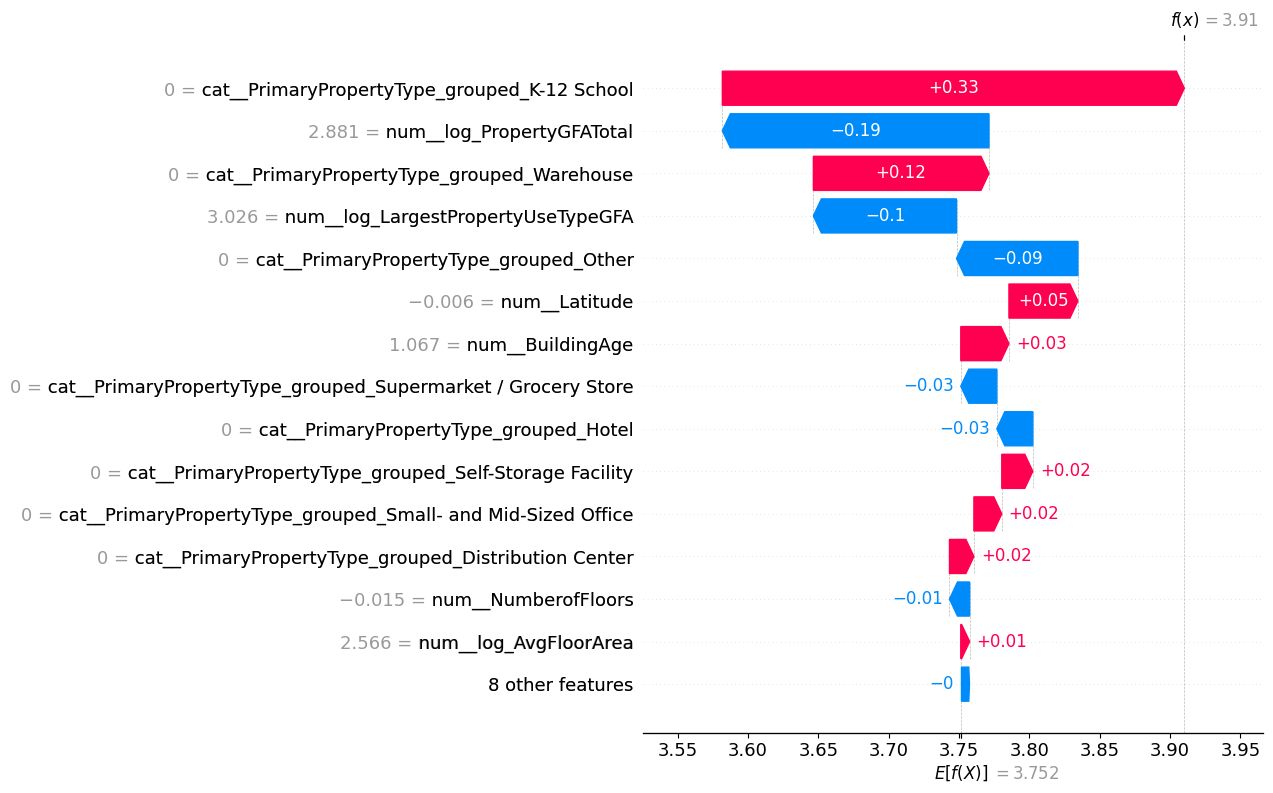


--- Analyse pour le cas : 'Le plus petit' (Index du bâtiment : 665) ---


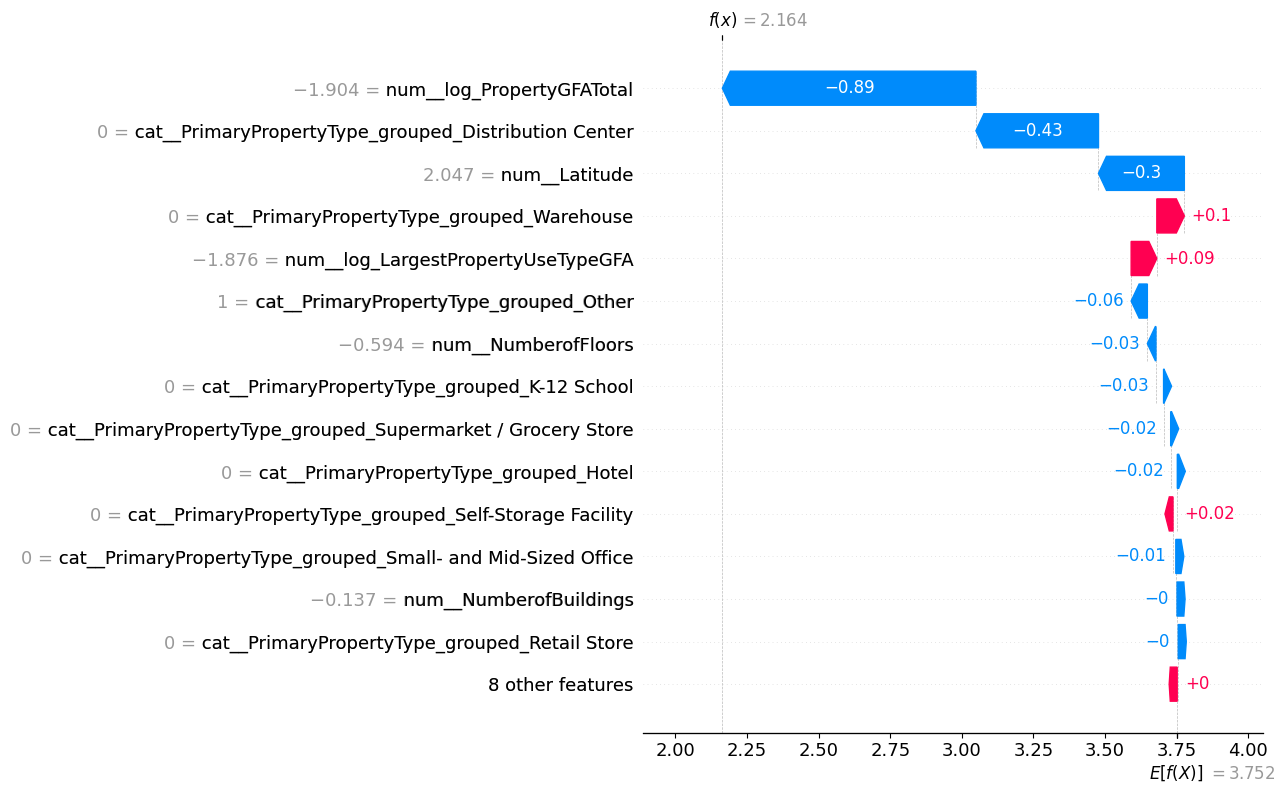

In [288]:
# PRÉPARATION POUR L'ANALYSE LOCALE SUR LE JEU DE TEST

print("\nPréparation des données de test pour l'analyse locale...")

# 1. Transformer les données de test avec le même préprocesseur
X_test_transformed = preproc.transform(X_test)

# 2. Créer le DataFrame transformé pour le jeu de test
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names, # On réutilise les mêmes noms de colonnes
    index=X_test.index
)

# 3. Calculer les valeurs SHAP spécifiquement pour le jeu de test
# C'est cette nouvelle variable qui sera utilisée pour les graphiques locaux
shap_values_test = explainer.shap_values(X_test_transformed_df)

print("-> Données de test prêtes pour l'analyse locale.")
# On boucle sur chaque bâtiment sélectionné
for nom_cas, idx in batiments_a_analyser.items():
    
    print(f"\n--- Analyse pour le cas : '{nom_cas}' (Index du bâtiment : {idx}) ---")
    
    # On crée l'objet "Explanation" nécessaire pour le graphique
    explanation_cas = shap.Explanation(
        values=shap_values[X_test.index.get_loc(idx)],
        base_values=explainer.expected_value,
        data=X_test_transformed_df.loc[idx],
        feature_names=X_test_transformed_df.columns.tolist()
    )
    
    # On génère le graphique waterfall
    shap.waterfall_plot(explanation_cas, max_display=15)

Analyse "locale" des différents bâtiments :

un entrepôt : les surfaces très petites (log total et log usage principal négatifs) tirent fortement la prédiction vers le bas (–0.44, –0.24).
Le fait d’être un entrepôt compense partiellement (–0.44 – 0.24 + 0.14 → net –0.54) car cette catégorie est historiquement énergivore.
Latitude (–1.949) ajoute un tout petit +0.05 (climat chaud).
Tous les autres attributs (étages, nombre de bâtiments, usages secondaires) ont un impact négligeable.
En synthèse, même si c’est un ##entrepôt (usage à forte empreinte), ici ses surfaces sont si réduites qu’il reste bien en-dessous de la prédiction moyenne, d’où f(x) ≃ 3.11.

un hôtel : Le moteur principal reste la surface de l’usage majeur (log_LargestPropertyUseTypeGFA = +0.32) : un très grand espace dédié tire la prédiction vers le haut.
la surface totale (log_PropertyGFATotal = –0.18) modère cette hausse, car l’hôtel n’est pas gigantesque dans l’absolu.
Le fait d’être un hôtel (Hotel=1) exerce un léger effet négatif (–0.04) par rapport à la catégorie de référence (ex. “Large Office”), signalant que ton parc hôtelier émet ici un peu moins que ces bureaux de grande taille.
Le statut “Warehouse=0” ajoute +0.13 (l’absence d’entrepôt fait monter la prédiction relative à cette référence énergie-intensive).
Les autres variables (âge, étages, localisation, usages secondaires) ne jouent qu’un rôle anecdotique, chacune oscillant entre –0.02 et +0.02.
En résumé, cet hôtel se situe parmi les plus émissifs car son usage principal est très volumineux, mais ses surfaces globales modérées et son statut d’hôtel tempèrent un peu la facture énergétique.

le plus grand : ici, c’est avant tout le fait de ne pas appartenir aux catégories “K-12 School” ou “Warehouse” qui pousse la prédiction très haut, malgré des surfaces importantes (qui modèrent un peu). 

le plus petit : la prédiction finale (log-émissions ≃ 2.164) est bien en-dessous de la moyenne (3.752) : c’est un petit bâtiment, non-entrepôt, dans une zone à latitude élevée.


Analyse du modèle avec l'ajout de la variable EnergyStarScore

In [289]:
 #On part du dataFrame qui contient toutes les features améliorées

df_subset = df_engineered.dropna(subset=['ENERGYSTARScore']).copy()

print(f"Taille du sous-ensemble avec EnergyStarScore : {len(df_subset)} lignes")

# On définit la cible (elle ne change pas)
target = 'log_TotalGHGEmissions'
y_subset = df_subset[target]

# --- On définit les listes de features pour les DEUX expériences ---

# Liste des features de base
base_features = [
    'log_PropertyGFATotal', 'log_LargestPropertyUseTypeGFA', 'log_AvgFloorArea',
    'BuildingAge', 'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'
]
categorical_features = ['PrimaryPropertyType_grouped']

# Expérience 1 : Features SANS le score
features_sans_score = base_features + categorical_features
X_sans_score = df_subset[features_sans_score]

# Expérience 2 : Features AVEC le score
features_avec_score = base_features + ['ENERGYSTARScore'] + categorical_features
X_avec_score = df_subset[features_avec_score]

Taille du sous-ensemble avec EnergyStarScore : 669 lignes


In [290]:
# Préprocesseur pour le modèle SANS le score (il est identique à votre 'preprocessor' actuel)
preprocessor_sans_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Préprocesseur pour le modèle AVEC le score
preprocessor_avec_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features + ['ENERGYSTARScore']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# --- Division des données ---
# On divise les deux jeux de données de la même manière pour une comparaison juste
X_train_sans, X_test_sans, y_train, y_test = train_test_split(X_sans_score, y_subset, test_size=0.2, random_state=42)
X_train_avec, X_test_avec, _, _ = train_test_split(X_avec_score, y_subset, test_size=0.2, random_state=42)

In [291]:

# On récupère les meilleurs hyperparamètres de votre GridSearchCV précédent
best_params = gs_final.best_params_
best_params_cleaned = {key.replace('model__', ''): value for key, value in best_params.items()}

# --- Modèle 1 : SANS le score ---
print("\n--- Entraînement SANS ENERGYSTARScore (sur le sous-ensemble) ---")
model_sans_score = Pipeline([
    ('prep', preprocessor_sans_score),
    ('model', GradientBoostingRegressor(**best_params_cleaned, random_state=42))
])
model_sans_score.fit(X_train_sans, y_train)
score_sans = model_sans_score.score(X_test_sans, y_test)

# --- Modèle 2 : AVEC le score ---
print("--- Entraînement AVEC ENERGYSTARScore ---")
model_avec_score = Pipeline([
    ('prep', preprocessor_avec_score),
    ('model', GradientBoostingRegressor(**best_params_cleaned, random_state=42))
])
model_avec_score.fit(X_train_avec, y_train)
score_avec = model_avec_score.score(X_test_avec, y_test)

# --- Comparaison finale ---
print("\n Résultats avant/après EnergyScore")
print(f"Score R^2 du modèle optimisé sur le dataset complet : {final_r2_score:.4f}")
print(f"Score R^2 SANS ENERGYSTARScore (sur le sous-ensemble) : {score_sans:.4f}")
print(f"Score R^2 AVEC ENERGYSTARScore (sur le sous-ensemble) : {score_avec:.4f}")


--- Entraînement SANS ENERGYSTARScore (sur le sous-ensemble) ---
--- Entraînement AVEC ENERGYSTARScore ---

 Résultats avant/après EnergyScore
Score R^2 du modèle optimisé sur le dataset complet : 0.4407
Score R^2 SANS ENERGYSTARScore (sur le sous-ensemble) : 0.4407
Score R^2 AVEC ENERGYSTARScore (sur le sous-ensemble) : 0.4709


L' ENERGYSTARScore est donc une variable très utile et prédictive. 
Il est donc fortement recommandé de mettre en place des actions pour collecter cette donnée pour les bâtiments où elle est actuellement manquante. 
Disposer de ce score pour l'ensemble du parc immobilier permettrait d'améliorer significativement la précision du modèle global.
Le fait que le score sur le "dataset complet" et sur le "sous-ensemble SANS score" soient identiques (0.4407) est une coïncidence intéressante. Cela suggère que le sous-ensemble des bâtiments ayant un score n'est ni plus facile ni plus difficile à prédire que la moyenne, ce qui rend l'expérience d'autant plus fiable.